In [1]:
import torch
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import cv2

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, AutoModelForSeq2SeqLM
from tqdm import tqdm
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing import image
from torchmetrics.classification import MultilabelF1Score
from sklearn.metrics import average_precision_score, ndcg_score

d:\Administrator\anaconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

In [3]:
genres = ["Crime", "Thriller", "Fantasy", "Horror", "Sci-Fi", "Comedy", "Documentary", "Adventure", "Film-Noir", "Animation", "Romance", "Drama", "Western", "Musical", "Action", "Mystery", "War", "Children\'s"]
mapping = {}
for i in range(len(genres)):
    mapping[i] = genres[i]
mapping

{0: 'Crime',
 1: 'Thriller',
 2: 'Fantasy',
 3: 'Horror',
 4: 'Sci-Fi',
 5: 'Comedy',
 6: 'Documentary',
 7: 'Adventure',
 8: 'Film-Noir',
 9: 'Animation',
 10: 'Romance',
 11: 'Drama',
 12: 'Western',
 13: 'Musical',
 14: 'Action',
 15: 'Mystery',
 16: 'War',
 17: "Children's"}

In [4]:
trainset = pd.read_csv('dataset/trainset.csv')
testset = pd.read_csv('dataset/testset.csv')
trainset.label = trainset.label.apply(lambda x: eval(x))
testset.label = testset.label.apply(lambda x: eval(x))
trainset.img_path = trainset.img_path.apply(lambda x: x.replace('\\', '/'))
testset.img_path = testset.img_path.apply(lambda x: x.replace('\\', '/'))

In [5]:
print(len(trainset), len(testset))

3106 777


In [6]:
def load_state_dict(checkpoint_path, use_ema=False, num_classes=1000):
    if checkpoint_path and os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        state_dict_key = 'state_dict'
        if isinstance(checkpoint, dict):
            if use_ema and 'state_dict_ema' in checkpoint:
                state_dict_key = 'state_dict_ema'
        if state_dict_key and state_dict_key in checkpoint:
            new_state_dict = OrderedDict()
            for k, v in checkpoint[state_dict_key].items():
                # strip `module.` prefix
                name = k[7:] if k.startswith('module') else k
                new_state_dict[name] = v
            state_dict = new_state_dict
        else:
            state_dict = checkpoint
#         _logger.info("Loaded {} from checkpoint '{}'".format(state_dict_key, checkpoint_path))
#         if num_classes != 1000:
#             # completely discard fully connected for all other differences between pretrained and created model
#             del state_dict['head' + '.weight']
#             del state_dict['head' + '.bias']

        return state_dict
    else:
#         _logger.error("No checkpoint found at '{}'".format(checkpoint_path))
        raise FileNotFoundError()


def load_for_transfer_learning(model, checkpoint_path, use_ema=False, strict=False, num_classes=1000):
    state_dict = load_state_dict(checkpoint_path, use_ema, num_classes)
    model.load_state_dict(state_dict, strict=strict)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
from models.t2t_vit import *

tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForSequenceClassification .from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=18)
model1.config.id2label = mapping

tokenizer2 = AutoTokenizer.from_pretrained("dduy193/plot-classification")
model2 = AutoModelForSequenceClassification.from_pretrained("dduy193/plot-classification")
model2.config.id2label = mapping

model3 = T2t_vit_14(img_size=224, num_classes=12)
model3.fc = torch.nn.Linear(2048, len(genres))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)
model3.to(device)
device

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adopt performer encoder for tokens-to-token


device(type='cuda')

In [9]:
class Multimodal(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fc1 = torch.nn.Linear(18, 18)
        self.fc2 = torch.nn.Linear(18, 18)
        self.fc3 = torch.nn.Linear(12, 18)

    def forward(self, 
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input):
        title_output = self.model1(title_input_ids, title_attention_mask)
        plot_output = self.model2(plot_input_ids, plot_attention_mask)
        image_output = self.model3(image_input)

        title_output = self.fc1(title_output.logits)
        plot_output = self.fc2(plot_output.logits)
        image_output = self.fc3(image_output)
        
        output = torch.add(title_output, plot_output)
        output = torch.add(output, image_output)
        return output

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, 
                 tokenizer1, tokenizer2, 
                 max_len1=64, max_len2=256,
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.df = df
        self.tokenizer1 = tokenizer1
        self.tokenizer2 = tokenizer2
        self.max_len1 = max_len1
        self.max_len2 = max_len2
        self.device = device
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        title = row['title']
        # Truncate title if it is too long
        if len(title) > self.max_len1:
            title = title[:self.max_len1]

        plot = row['plot']
        # Truncate plot if it is too long
        if len(plot) > self.max_len2:
            plot = plot[:self.max_len2]

        label = row['label']
        title_encoding = self.tokenizer1(title, truncation=True, padding='max_length', max_length=self.max_len1, return_tensors='pt')
        plot_encoding = self.tokenizer2(plot, truncation=True, padding='max_length', max_length=self.max_len2, return_tensors='pt')
        
        image_path = 'dataset/' + row['img_path']
        if os.path.exists(image_path):
            image_input = image.load_img(image_path)
            image_input = self.transform(image_input)
        else:
            image_input = torch.zeros((3, 224, 224))
        
        return {
            'title': title,
            'plot': plot,
            'title_input_ids': title_encoding['input_ids'].squeeze(),
            'title_attention_mask': title_encoding['attention_mask'].squeeze(),
            'plot_input_ids': plot_encoding['input_ids'].squeeze(),
            'plot_attention_mask': plot_encoding['attention_mask'].squeeze(),
            'image_input': image_input,
            'label': torch.FloatTensor(label)
        }

In [11]:
trainset.head()

,title,img_path,label,plot
0,Washington Square (1997),ml1m-images/1650.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Washington Square is a 1997 American film abou...
1,"Net, The (1995)",ml1m-images/185.jpg,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Net is a 1995 American film directed by James ...
2,Batman Returns (1992),ml1m-images/1377.jpg,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",Batman returns to the Batman universe after a ...
3,"Boys from Brazil, The (1978)",ml1m-images/3204.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The movie Boys from Brazil, The (1978) is a ro..."
4,Dear Jesse (1997),ml1m-images/1901.jpg,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Dear Jesse is a 1997 American drama film about...


In [12]:
trainset = CustomDataset(df=trainset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                   max_len1=64, max_len2=256,
                   device=device)
testset = CustomDataset(df=testset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                  max_len1=64, max_len2=256,
                  device=device)

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


Title:  Tombstone (1993)
Plot:  Tombstone is a 1993 horror film about a man named Tombstone who is convicted of murdering his wife and her lover. He is sentenced to life in prison for the murder. The film explores themes of societal decay, the dangers of drug use, and the consequences of
Label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


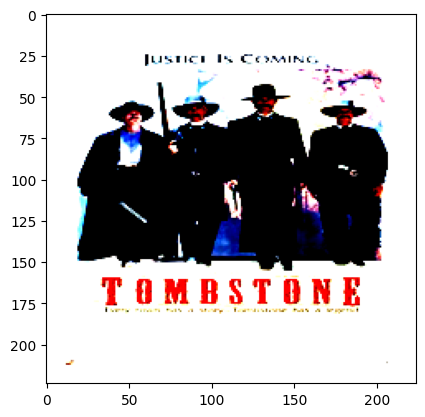

In [14]:
sample = next(iter(testloader))

# First sample of the batch
print('Title: ', sample['title'][3])
print('Plot: ', sample['plot'][3])
print('Label: ', sample['label'][3])
plt.imshow(sample['image_input'][3].permute(1, 2, 0))

In [15]:
model = Multimodal(model1, model2, model3)
model.to(device)
device

# Freeze layers
for param in model.model2.parameters():
    param.requires_grad = False
    
model

Multimodal(
  (model1): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ff

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)

In [17]:
history_loss = []
history_f1 = []
history_mapk = []
history_ndcg = []
def train(epoch):
    model.train()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []
    for _, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        title_input_ids = data['title_input_ids'].to(device)
        title_attention_mask = data['title_attention_mask'].to(device)
        plot_input_ids = data['plot_input_ids'].to(device)
        plot_attention_mask = data['plot_attention_mask'].to(device)
        image_input = data['image_input'].to(device)
        label = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(
            title_input_ids, title_attention_mask,
            plot_input_ids, plot_attention_mask,
            image_input
        )
        
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()

        f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    maps = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Epoch: {epoch}, Train Loss: {loss.item()}, Train F1: {f1.compute().item()}, Train MAP: {maps}, Train NDCG: {ndcg}')
    history_loss.append(loss.item())
    history_f1.append(f1.compute().item())
    history_mapk.append(maps)
    history_ndcg.append(ndcg)

In [18]:
for epoch in range(32):
    train(epoch)

100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Epoch: 0, Train Loss: 0.8853269815444946, Train F1: 0.10773681849241257, Train MAP: 0.23696752904848717, Train NDCG: 0.42870758618965776


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 1, Train Loss: 0.6533972024917603, Train F1: 0.10123218595981598, Train MAP: 0.2777569920511949, Train NDCG: 0.4627714280453418


100%|██████████| 98/98 [01:01<00:00,  1.60it/s]


Epoch: 2, Train Loss: 0.407865047454834, Train F1: 0.10155370086431503, Train MAP: 0.3250950623588142, Train NDCG: 0.5012350460722843


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 3, Train Loss: 0.456891268491745, Train F1: 0.10411819070577621, Train MAP: 0.3668373153034245, Train NDCG: 0.5348374173097997


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 4, Train Loss: 1.175386667251587, Train F1: 0.11883862316608429, Train MAP: 0.40943819114511043, Train NDCG: 0.5691392851118786


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 5, Train Loss: 0.13702711462974548, Train F1: 0.14506718516349792, Train MAP: 0.4697332761764152, Train NDCG: 0.61800191025601


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 6, Train Loss: 0.17222853004932404, Train F1: 0.1768987476825714, Train MAP: 0.5444319625934313, Train NDCG: 0.6774252063982653


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 7, Train Loss: 0.3990394175052643, Train F1: 0.20442189276218414, Train MAP: 0.6076110406167979, Train NDCG: 0.7271343204028966


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 8, Train Loss: 0.17079178988933563, Train F1: 0.22915871441364288, Train MAP: 0.6571398380322995, Train NDCG: 0.7649795788669925


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 9, Train Loss: 0.30872735381126404, Train F1: 0.2529810667037964, Train MAP: 0.6928225123900478, Train NDCG: 0.7918504064128169


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 10, Train Loss: 0.44308915734291077, Train F1: 0.27577704191207886, Train MAP: 0.720845390661354, Train NDCG: 0.8125306630613505


100%|██████████| 98/98 [00:59<00:00,  1.63it/s]


Epoch: 11, Train Loss: 0.38552573323249817, Train F1: 0.2956537902355194, Train MAP: 0.7378384675190668, Train NDCG: 0.825087308729262


100%|██████████| 98/98 [00:59<00:00,  1.63it/s]


Epoch: 12, Train Loss: 0.047279760241508484, Train F1: 0.3186436593532562, Train MAP: 0.7547184739705146, Train NDCG: 0.8360595388616074


100%|██████████| 98/98 [00:59<00:00,  1.63it/s]


Epoch: 13, Train Loss: 0.242083340883255, Train F1: 0.32760679721832275, Train MAP: 0.7725751620238571, Train NDCG: 0.8490684778327323


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 14, Train Loss: 0.0261149350553751, Train F1: 0.34949803352355957, Train MAP: 0.7890458356511961, Train NDCG: 0.8606610253278766


100%|██████████| 98/98 [00:59<00:00,  1.65it/s]


Epoch: 15, Train Loss: 0.550279438495636, Train F1: 0.372291624546051, Train MAP: 0.7975623907553095, Train NDCG: 0.8662443084147322


100%|██████████| 98/98 [00:59<00:00,  1.63it/s]


Epoch: 16, Train Loss: 0.03683365881443024, Train F1: 0.390957236289978, Train MAP: 0.8142829091339563, Train NDCG: 0.8776421844626408


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 17, Train Loss: 0.009783906862139702, Train F1: 0.41767993569374084, Train MAP: 0.8300222203889678, Train NDCG: 0.8886326468333646


100%|██████████| 98/98 [01:00<00:00,  1.63it/s]


Epoch: 18, Train Loss: 0.10562895238399506, Train F1: 0.43810901045799255, Train MAP: 0.8453617248552336, Train NDCG: 0.8987079530173536


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 19, Train Loss: 0.19021864235401154, Train F1: 0.46329522132873535, Train MAP: 0.8537923209786017, Train NDCG: 0.904036501033765


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 20, Train Loss: 0.07053378969430923, Train F1: 0.4698871970176697, Train MAP: 0.8659161308708911, Train NDCG: 0.9128912148556408


100%|██████████| 98/98 [00:59<00:00,  1.64it/s]


Epoch: 21, Train Loss: 0.18602649867534637, Train F1: 0.5141342282295227, Train MAP: 0.8845003565845106, Train NDCG: 0.9257646947372803


100%|██████████| 98/98 [00:58<00:00,  1.69it/s]


Epoch: 22, Train Loss: 0.05855454504489899, Train F1: 0.5203899145126343, Train MAP: 0.8944749937176597, Train NDCG: 0.9324082045092744


100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch: 23, Train Loss: 0.07747451215982437, Train F1: 0.5621274709701538, Train MAP: 0.9052907167734731, Train NDCG: 0.9398860929402829


100%|██████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch: 24, Train Loss: 0.008769987151026726, Train F1: 0.588034987449646, Train MAP: 0.9190438083694732, Train NDCG: 0.9489076023611693


100%|██████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch: 25, Train Loss: 0.04092865437269211, Train F1: 0.6091924905776978, Train MAP: 0.9288419362688566, Train NDCG: 0.9552938751295086


100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch: 26, Train Loss: 0.24120551347732544, Train F1: 0.6334744691848755, Train MAP: 0.9377766705883538, Train NDCG: 0.9614124314022167


100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch: 27, Train Loss: 0.08015983551740646, Train F1: 0.6573605537414551, Train MAP: 0.9440352263406314, Train NDCG: 0.9659998975740935


100%|██████████| 98/98 [00:56<00:00,  1.72it/s]


Epoch: 28, Train Loss: 0.041665494441986084, Train F1: 0.6816953420639038, Train MAP: 0.9506500664056484, Train NDCG: 0.9700261249996807


100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch: 29, Train Loss: 0.03932257369160652, Train F1: 0.7037678956985474, Train MAP: 0.9567038684057926, Train NDCG: 0.9736630890897058


100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch: 30, Train Loss: 0.0196430291980505, Train F1: 0.7209650278091431, Train MAP: 0.9634489624545163, Train NDCG: 0.9782257008669774


100%|██████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch: 31, Train Loss: 0.20499339699745178, Train F1: 0.7514973878860474, Train MAP: 0.9690642630309688, Train NDCG: 0.9817754672565653


In [19]:
# Save model
torch.save(model.state_dict(), 'partially_frozen_multimodel.pt')

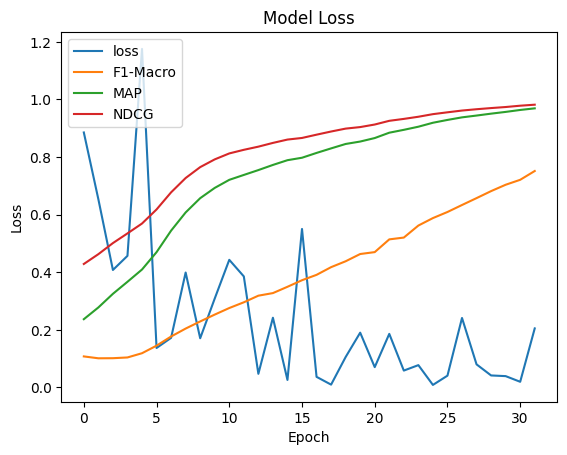

In [20]:
# Visualize
plt.plot(history_loss)
plt.plot(history_f1)
plt.plot(history_mapk)
plt.plot(history_ndcg)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'F1-Macro', 'MAP', 'NDCG'], loc='upper left')
plt.show()

In [21]:
# Validation
def test(testing_loader):
    model.eval()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0), total=len(testing_loader)):
            title_input_ids = data['title_input_ids'].to(device)
            title_attention_mask = data['title_attention_mask'].to(device)
            plot_input_ids = data['plot_input_ids'].to(device)
            plot_attention_mask = data['plot_attention_mask'].to(device)
            image_input = data['image_input'].to(device)
            label = data['label'].to(device)

            outputs = model(
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input
            )
            f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    mapp = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Test F1: {f1.compute().item()}, Test MAP: {mapp}, Test NDCG: {ndcg}')

In [22]:
test(testloader)

100%|██████████| 25/25 [00:08<00:00,  2.82it/s]

Test F1: 0.2754491865634918, Test MAP: 0.5707491582491583, Test NDCG: 0.6871613065654353


In [23]:
def inference(title, plot, image_input, tokenizer1=tokenizer1, tokenizer2=tokenizer2, model=model, genres=genres, device=device):
    title_input = tokenizer1(title, return_tensors='pt', padding=True, truncation=True)
    title_input_ids = title_input['input_ids'].to(device)
    title_attention_mask = title_input['attention_mask'].to(device)

    plot_input = tokenizer2(plot, return_tensors='pt', padding=True, truncation=True)
    plot_input_ids = plot_input['input_ids'].to(device)
    plot_attention_mask = plot_input['attention_mask'].to(device)

    image_input = image_input.to(device)
    print(title)
    print(plot)
    plt.imshow(image_input.permute(1, 2, 0).cpu().detach().numpy())

    output = model(title_input_ids, title_attention_mask, plot_input_ids, plot_attention_mask, image_input.unsqueeze(0))
    output = torch.sigmoid(output)
    output = output.cpu().detach().numpy()
    output = np.where(output > 0.5, 1, 0)
    output = output.squeeze()
    output = np.where(output == 1)[0]
    output = [genres[i] for i in output]
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


House II: The Second Story (1987)
House II: The Second Story is a movie about a group of friends who are trying to survive in a small town in the 1930s. They are forced to live in a house that is owned by a wealthy businessman, but they are forced to work together to survive. The story fol


['Horror', 'Comedy']

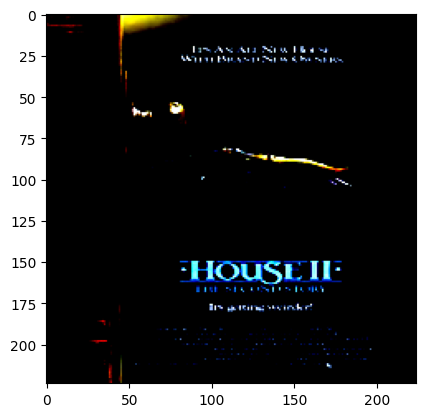

In [24]:
inference(sample['title'][1], sample['plot'][1], sample['image_input'][1])